In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.api import VAR

import tensorflow as tf

In [2]:
save_dir = 'Datasets'
csv_filename = 'jena_climate_2009_2016.csv.zip'

zip_path = tf.keras.utils.get_file(
    fname=csv_filename,
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    cache_dir=save_dir,
    extract=True
)

In [3]:
df = pd.read_csv(r'Datasets\datasets\jena_climate_2009_2016.csv.zip')

df = df.rename(columns={'Date Time': 'date', 'p (mbar)': 'p', 'T (degC)': 'temp'})

df.head(7)

,date,p,temp,tempK,tdew,rh,vpmax,vpact,vpdef,sh,h2oc,rho,wv,max_wv,wd
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3
5,01.01.2009 01:00:00,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
6,01.01.2009 01:10:00,996.50,-7.62,265.81,-8.30,94.8,3.44,3.26,0.18,2.04,3.27,1305.68,0.18,0.63,166.5


In [4]:
df['date'] = pd.to_datetime(df['date'], format='%d.%m.%Y %H:%M:%S')

max_date = df['date'].max()

two_years = max_date.replace(year=max_date.year - 5)

df = df[df['date'] >= two_years]

df.head(7)

,date,p,temp,tempK,tdew,rh,vpmax,vpact,vpdef,sh,h2oc,rho,wv,max_wv,wd
157821,2012-01-01 00:00:00,985.43,2.30,276.62,1.73,96.0,7.21,6.92,0.29,4.38,7.03,1242.91,1.86,2.80,190.4
157822,2012-01-01 00:10:00,985.43,2.35,276.67,1.78,96.0,7.24,6.95,0.29,4.40,7.05,1242.67,1.46,2.16,210.3
157823,2012-01-01 00:20:00,985.44,2.46,276.78,1.91,96.1,7.30,7.01,0.28,4.44,7.12,1242.15,1.55,2.32,193.5
157824,2012-01-01 00:30:00,985.40,2.51,276.83,1.92,95.9,7.32,7.02,0.30,4.44,7.12,1241.91,1.60,2.18,201.6
157825,2012-01-01 00:40:00,985.40,2.60,276.92,2.01,95.9,7.37,7.07,0.30,4.47,7.17,1241.46,1.43,2.32,179.8
157826,2012-01-01 00:50:00,985.52,2.64,276.95,2.06,95.9,7.39,7.09,0.30,4.48,7.19,1241.41,1.33,1.96,198.5
157827,2012-01-01 01:00:00,985.56,2.72,277.03,2.12,95.8,7.43,7.12,0.31,4.50,7.22,1241.11,1.39,2.00,201.2


In [5]:
df['day'] = df['date'].dt.date

daily_means = df.groupby('day').mean().reset_index()
daily_means['day'] = pd.to_datetime(daily_means['day'], format='%d.%m.%Y %H:%M:%S')
daily_means.set_index('day', inplace=True)
daily_means = daily_means.drop(columns='date')

daily_means.head(7)

,p,temp,tempK,tdew,rh,vpmax,vpact,vpdef,sh,h2oc,rho,wv,max_wv,wd
day,,,,,,,,,,,,,,
2012-01-01,985.231736,7.769097,282.127500,5.944861,88.604167,10.803403,9.418750,1.385208,5.968403,9.560069,1217.485625,3.301389,5.046042,193.572778
2012-01-02,982.234028,8.635417,283.246458,5.770000,82.561111,11.420347,9.287847,2.132361,5.905764,9.460139,1210.102292,3.896181,6.162639,225.351042
2012-01-03,986.771875,5.074861,279.301528,0.487639,72.789306,8.902500,6.375417,2.527847,4.030903,6.464236,1232.637361,6.681806,10.033264,213.103472
2012-01-04,983.729375,5.009375,279.478611,-0.516736,67.517986,8.755694,5.920208,2.836319,3.752639,6.019167,1229.181111,3.721944,6.776111,230.527083
2012-01-05,964.260000,3.251319,279.304444,0.134583,80.171181,7.741944,6.182083,1.559306,3.998056,6.411944,1212.333264,6.023958,9.941111,232.019444
2012-01-06,981.556319,2.484583,277.119236,-0.970833,78.467986,7.321806,5.708056,1.614028,3.625625,5.816111,1237.776944,2.645347,5.241181,266.171875
2012-01-07,986.455625,3.160278,277.400278,-0.018681,79.672431,7.677222,6.123472,1.554375,3.871111,6.208750,1240.741181,3.663194,6.294306,229.125000


In [6]:
df_temp = daily_means['temp']

df_temp.head(7)

day
2012-01-01    7.769097
2012-01-02    8.635417
2012-01-03    5.074861
2012-01-04    5.009375
2012-01-05    3.251319
2012-01-06    2.484583
2012-01-07    3.160278
Name: temp, dtype: float64

In [7]:
def plot(data, name):
    plt.figure(figsize=(12, 6))
    plt.plot(data.index, data)
    plt.title(f'{name} с 2011 по 2016 годы')
    plt.xlabel('Период')
    plt.ylabel(f'{name}')
    plt.show()

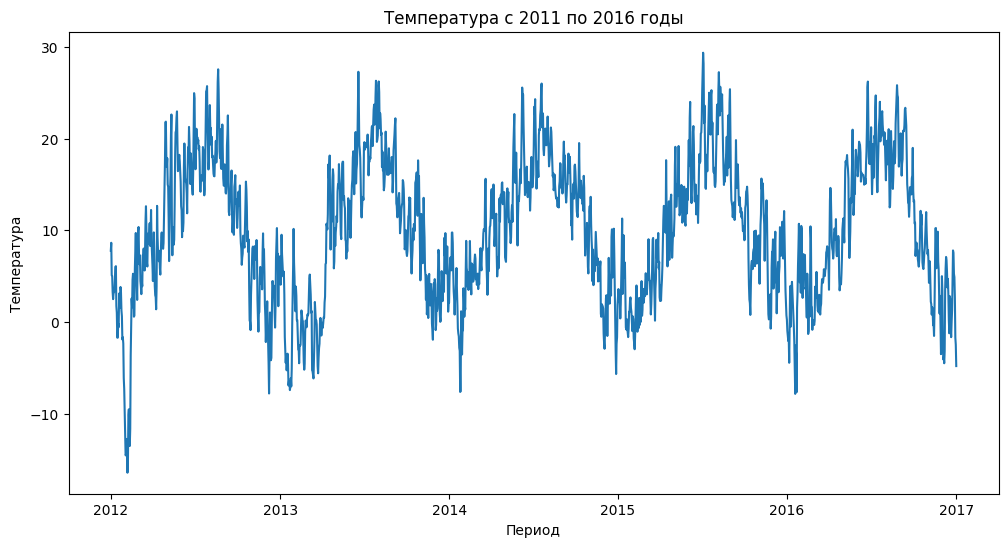

In [8]:
plot(df_temp, 'Температура')

In [9]:
def fuller(data):
    result = adfuller(data)
    print('ADF статистика:', result[0])
    print('p-значение:', result[1])
    print('Критические значения:')
    for key, value in result[4].items():
        print(f'  {key}: {value}')

In [10]:
fuller(df_temp)

ADF статистика: -3.089359227384714
p-значение: 0.027350740825519623
Критические значения:
  1%: -3.433968010099092
  5%: -2.8631381499714745
  10%: -2.567620802173316


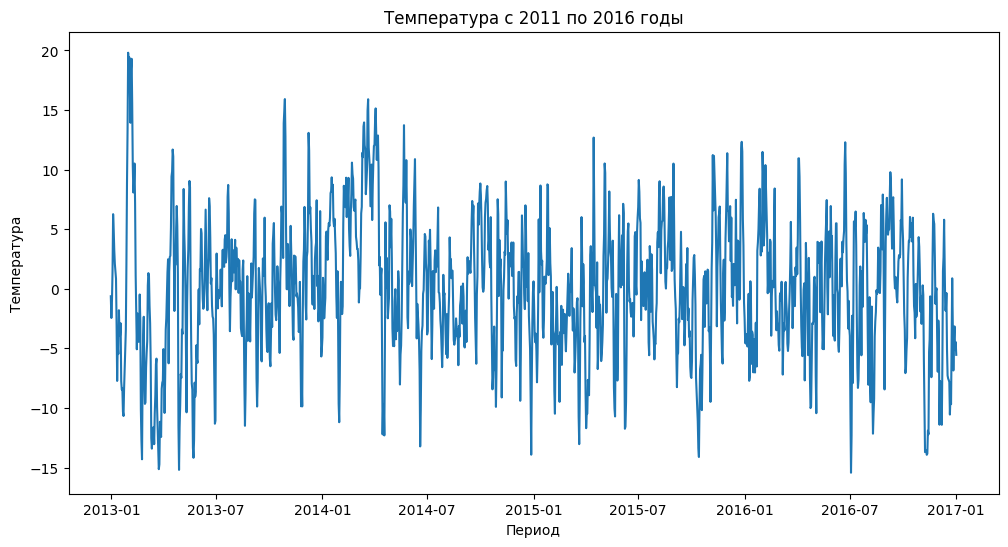

In [11]:
diff = df_temp - df_temp.shift(365)

diff.dropna(inplace=True)

plot(diff, 'Температура')

In [12]:
fuller(diff)

ADF статистика: -11.884932512186703
p-значение: 6.054748769872044e-22
Критические значения:
  1%: -3.434843038681996
  5%: -2.8635243777871286
  10%: -2.56782646544019


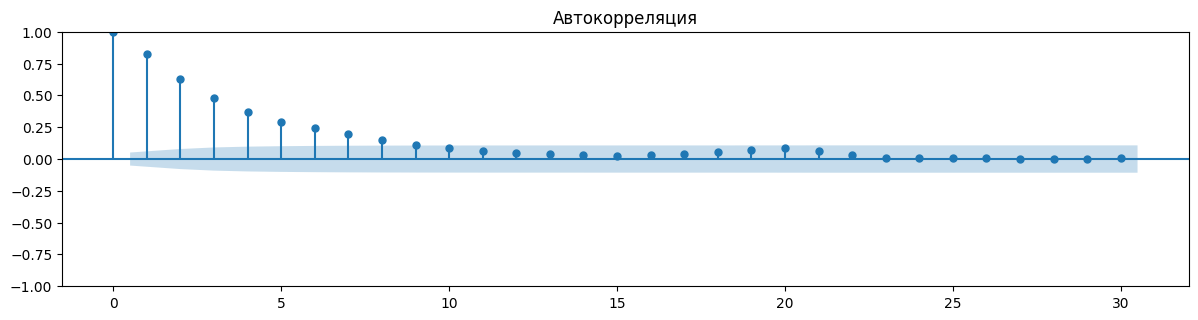

In [13]:
plt.figure(figsize=(12, 6))
plt.subplot(211)
plot_acf(diff, lags=30, ax=plt.gca())
plt.title('Автокорреляция')
plt.tight_layout()
plt.show()

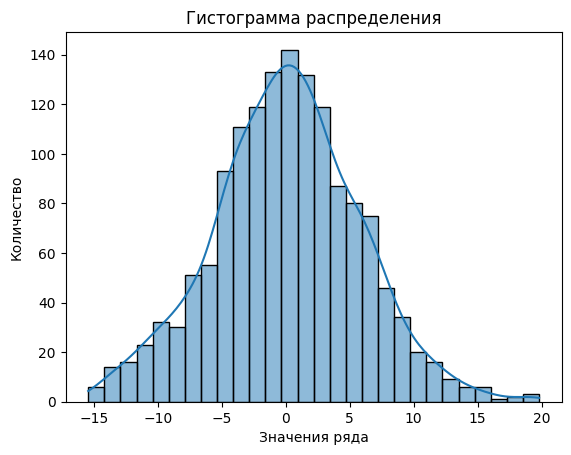

In [14]:
sns.histplot(diff, kde='norm')
plt.xlabel('Значения ряда')
plt.ylabel('Количество')
plt.title('Гистограмма распределения')
plt.show()

In [15]:
one_year = max_date.replace(year=max_date.year - 1)

mean_value = df_temp[-365:].mean()

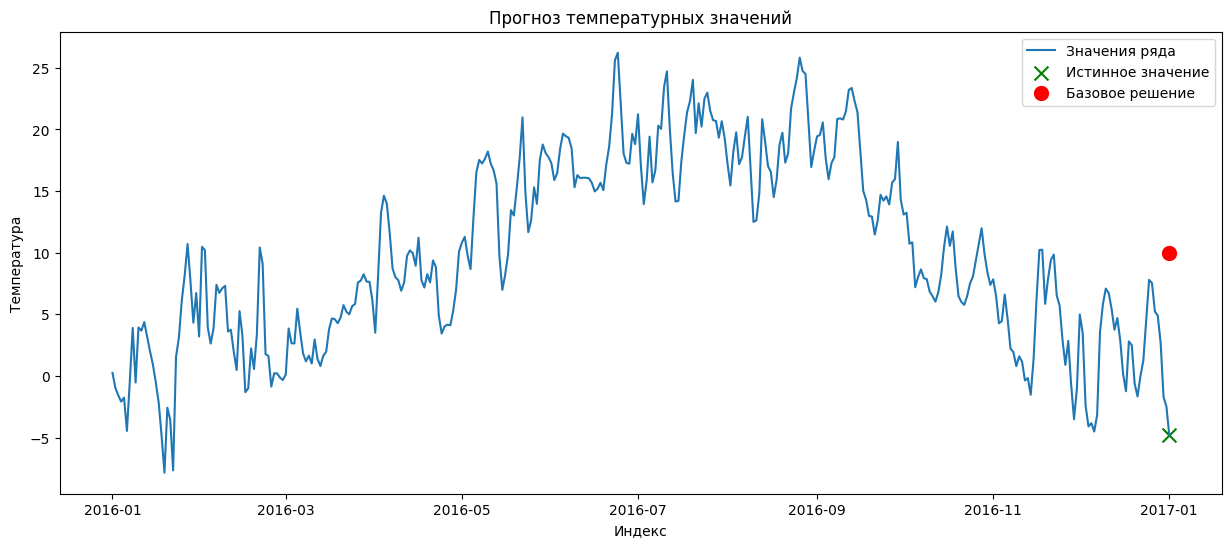

In [81]:
plt.figure(figsize=(15, 6))

last_100_values = df_temp[-365:]
plt.plot(last_100_values.index, last_100_values, label='Значения ряда')

plt.scatter(df_temp.index[-1], df_temp[-1:], marker='x', label='Истинное значение', color='g', s=100)

plt.scatter(last_100_values.index[-1], mean_value, color='r', label='Базовое решение', s=100)

plt.legend()
plt.title('Прогноз температурных значений')
plt.xlabel('Индекс')
plt.ylabel('Температура')
plt.show()

In [82]:
%%time
p = range(0,10)
d = range(0,3)
q = range(0,3)

pdq = list(itertools.product(p, d, q))
best_pdq = (0,0,0)
best_bic = np.inf

for params in pdq:
    model_test = ARIMA(df_temp, order = params)
    result_test = model_test.fit()
    
    if result_test.bic < best_bic:
        best_pdq = params
        best_bic = result_test.bic
    
p, d, q = best_pdq

print(f'Порядок авторегресии: {p}\nПорядок дифференцирования: {d}\nПорядок скользящего среднего: {q}')
print(f'Наилучшее значение BIC: {best_bic}')

Порядок авторегресии: 1
Порядок дифференцирования: 1
Порядок скользящего среднего: 2
Наилучшее значение BIC: 8178.491735567344
CPU times: total: 3min 32s
Wall time: 1min 32s


In [54]:
model = ARIMA(df_temp, order=(p, d, q))
model_fit = model.fit()

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                   temp   No. Observations:                 1826
Model:                 ARIMA(1, 1, 2)   Log Likelihood               -4074.227
Date:                Sun, 15 Dec 2024   AIC                           8156.454
Time:                        13:25:27   BIC                           8178.492
Sample:                             0   HQIC                          8164.584
                               - 1826                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6836      0.034     20.037      0.000       0.617       0.750
ma.L1         -0.6179      0.036    -17.125      0.000      -0.689      -0.547
ma.L2         -0.2629      0.023    -11.355      0.0

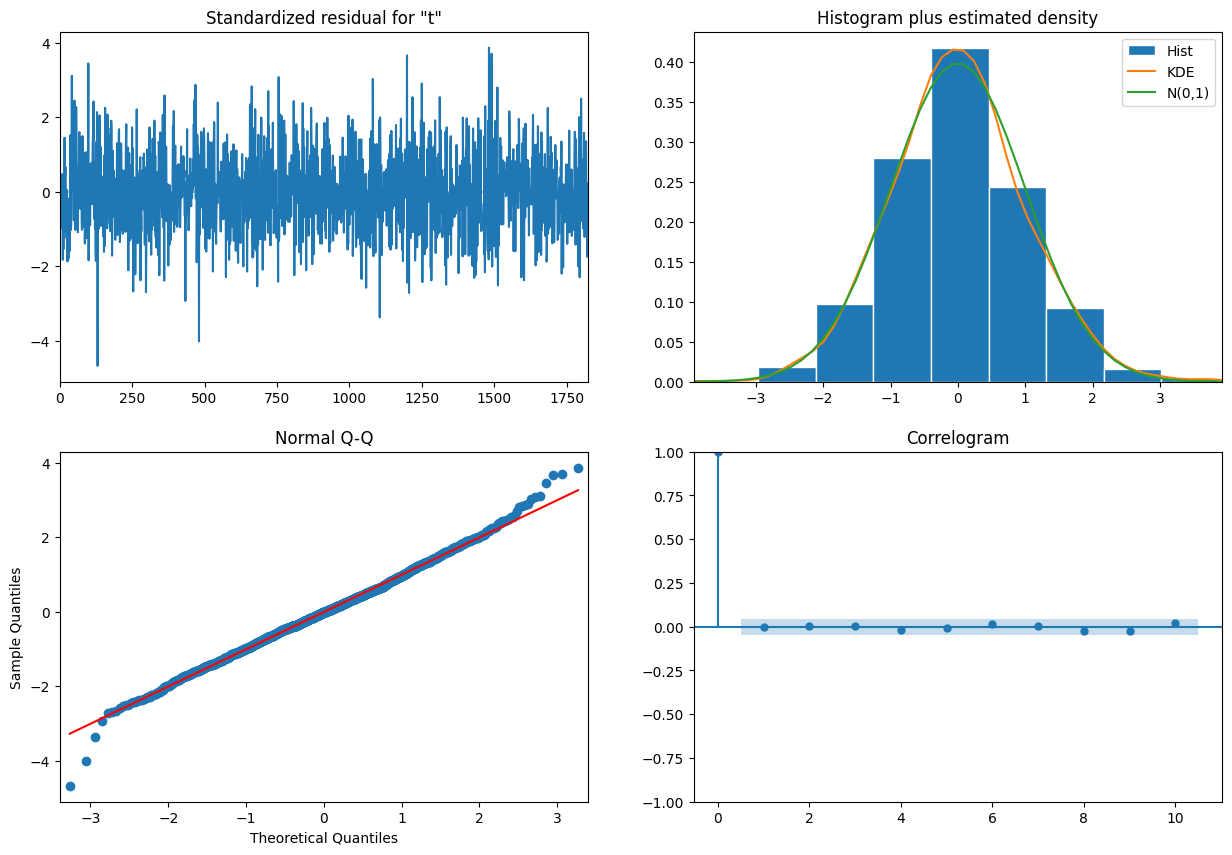

In [55]:
model_fit.plot_diagnostics(figsize=(15, 10))
plt.show()

In [84]:
def plot_forecast(data, model, order, threshold):
    model = model(data, order=order)
    model_fit = model.fit()

    forecast = model_fit.get_prediction(start=0, end=len(df_temp)-1)
    forecast_ci = forecast.conf_int()

    threshold = threshold

    mean_value = forecast_ci[['lower temp', 'upper temp']].mean().mean()

    def replace_anomalies_with_mean(row):
        if abs(row['lower temp']) > threshold:
            row['lower temp'] = mean_value
        if abs(row['upper temp']) > threshold:
            row['upper temp'] = mean_value
        return row

    forecast_ci = forecast_ci.apply(replace_anomalies_with_mean, axis=1)

    plt.figure(figsize=(15,5))
    plt.plot(data[-200:-7], label="Фактические значения", linewidth=4)
    plt.fill_between(forecast_ci.index[-200:-7],
    forecast_ci.iloc[:, 0][-200:-7],
    forecast_ci.iloc[:, 1][-200:-7], color='k', alpha=.2, label='Доверительный интервал прогноза')
    plt.plot(forecast.predicted_mean[-200:-7], color='red', label="Прогноз", linewidth=3)

    plt.plot(forecast.predicted_mean[-7:], color='red', linestyle='dashed', linewidth=3)
    plt.fill_between(forecast_ci.index[-7:],
    forecast_ci.iloc[:, 0][-7:],
    forecast_ci.iloc[:, 1][-7:], color='k', alpha=.2)

    plt.legend(fontsize=15)

    plt.title('Прогноз')

    plt.show()

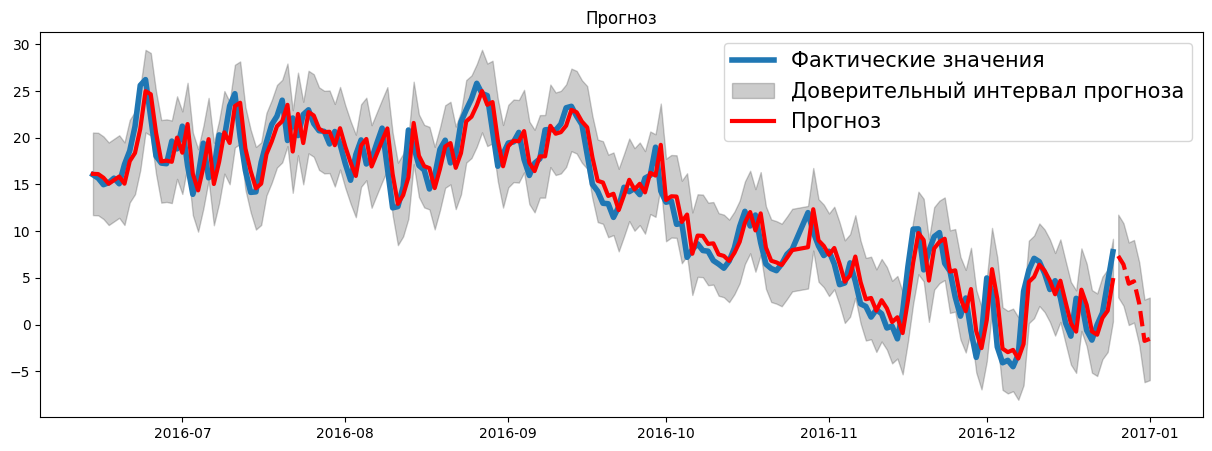

In [85]:
plot_forecast(df_temp, ARIMA, (p, d, q), 100)

In [57]:
forecast = model_fit.predict()

mse = mean_squared_error(df_temp, forecast)

print(f'MSE: {mse}')

MSE: 5.118719979651373


In [58]:
%%time
def arima_objective_function(params):
    global data_values
    
    p, d, q = params
    
    try:
        model = ARIMA(data_values, order=(p, d, q))
        predictions = model.fit()
        y_pred = predictions.predict()
        mse = mean_squared_error(data_values, y_pred)
    except:
        mse = float('inf')
    
    return mse

param_space = [hp.choice('p', range(0, 20)), hp.choice('d', range(0, 20)), hp.choice('q', range(0, 20))]

data_values = df_temp

trials = Trials()
best = fmin(fn=arima_objective_function, space=param_space, algo=tpe.suggest, max_evals=30, trials=trials)

100%|██████████| 30/30 [11:59<00:00, 23.99s/trial, best loss: 4.997239111889129]
CPU times: total: 27min 32s
Wall time: 11min 59s


In [59]:
print(best)
best_loss = trials.best_trial['result']['loss']

p, d, q = best['p'], best['d'], best['q']

print(f'Порядок авторегресии: {p}\nПорядок дифференцирования: {d}\nПорядок скользящего среднего: {q}')
print(f'Наилучшее значение MSE: {best_loss}')

{'d': 0, 'p': 12, 'q': 19}
Порядок авторегресии: 12
Порядок дифференцирования: 0
Порядок скользящего среднего: 19
Наилучшее значение MSE: 4.997239111889129


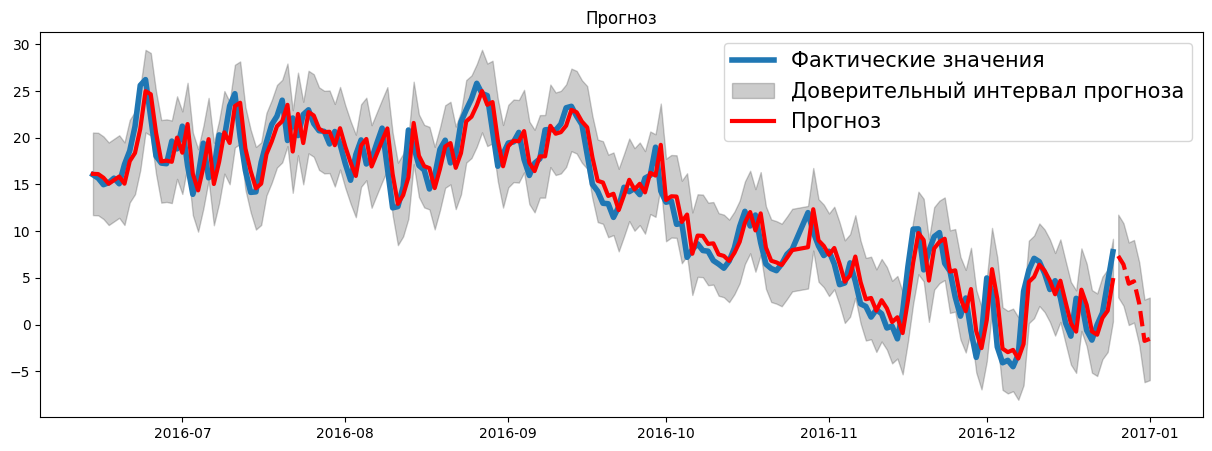

In [86]:
plot_forecast(df_temp, ARIMA, (p, d, q), 100)

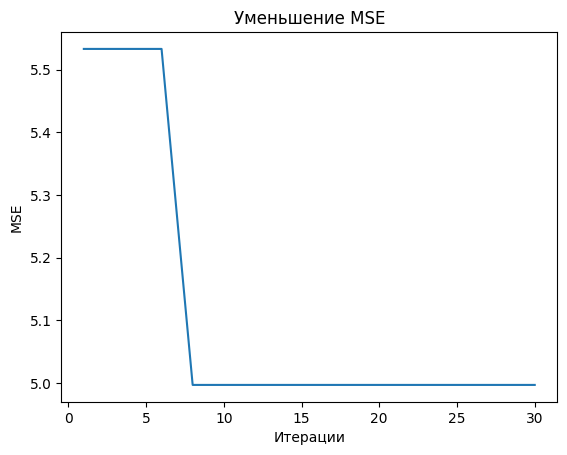

In [61]:
losses = [trial['result']['loss'] for trial in trials.trials]
best_losses = [min(losses[:i+1]) for i in range(len(losses))]

plt.plot(range(1, len(losses)+1), best_losses)
plt.xlabel('Итерации')
plt.ylabel('MSE')
plt.title('Уменьшение MSE')
plt.show()

In [62]:
data_values.mean()

9.982572781415177

In [63]:
data_values.var()

58.02199276060119

# VAR

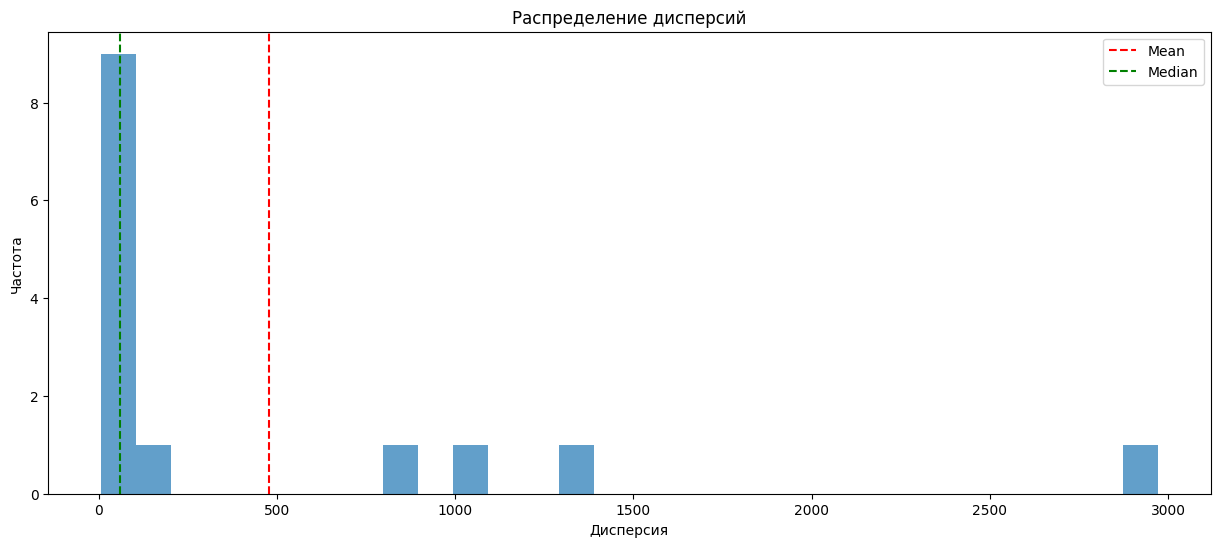

In [16]:
plt.figure(figsize=(15,6))

variances = daily_means.var()

plt.hist(variances, bins=30, alpha=0.7)
plt.axvline(x=variances.mean(), color='r', linestyle='--', label='Mean')
plt.axvline(x=variances.median(), color='g', linestyle='--', label='Median')
plt.title('Распределение дисперсий')
plt.xlabel('Дисперсия')
plt.ylabel('Частота')
plt.legend()
plt.show()

In [17]:
var_dict = {col: daily_means[col].var() for col in daily_means.columns}

var_df = pd.DataFrame.from_dict(var_dict, orient='index', columns=['Variance'])

var_df

,Variance
p,64.704636
temp,58.021993
tempK,59.365822
tdew,40.079223
rh,129.183403
vpmax,49.156921
vpact,16.675864
vpdef,13.621460
sh,6.719814
h2oc,17.078905


In [18]:
selected_features = var_df[var_df['Variance'] > 50].index

filtered_data = daily_means[selected_features]

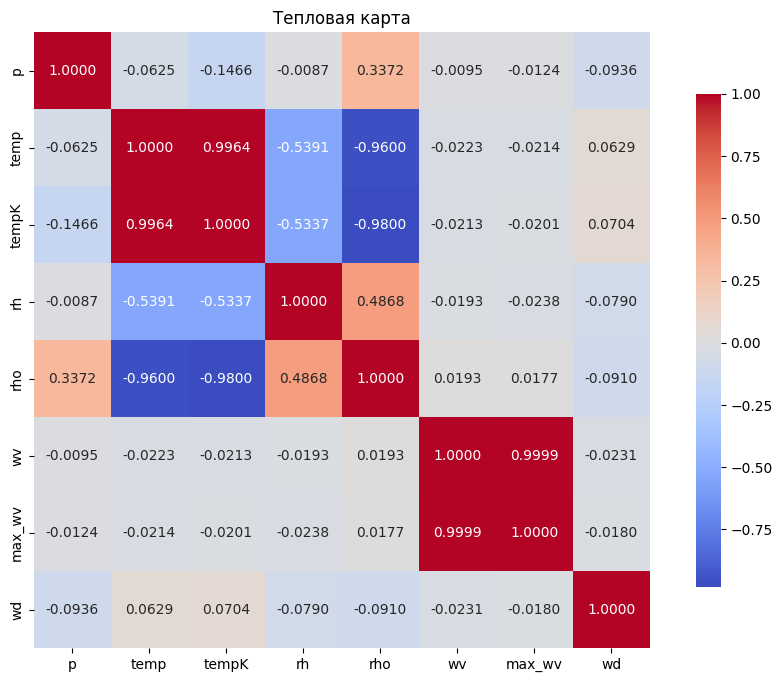

In [19]:
cov_matrix = filtered_data.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(cov_matrix, annot=True, fmt='.4f', cmap='coolwarm', square=True, 
            cbar_kws={"shrink": .8}, xticklabels=cov_matrix.columns, yticklabels=cov_matrix.columns)
plt.title('Тепловая карта')
plt.show()

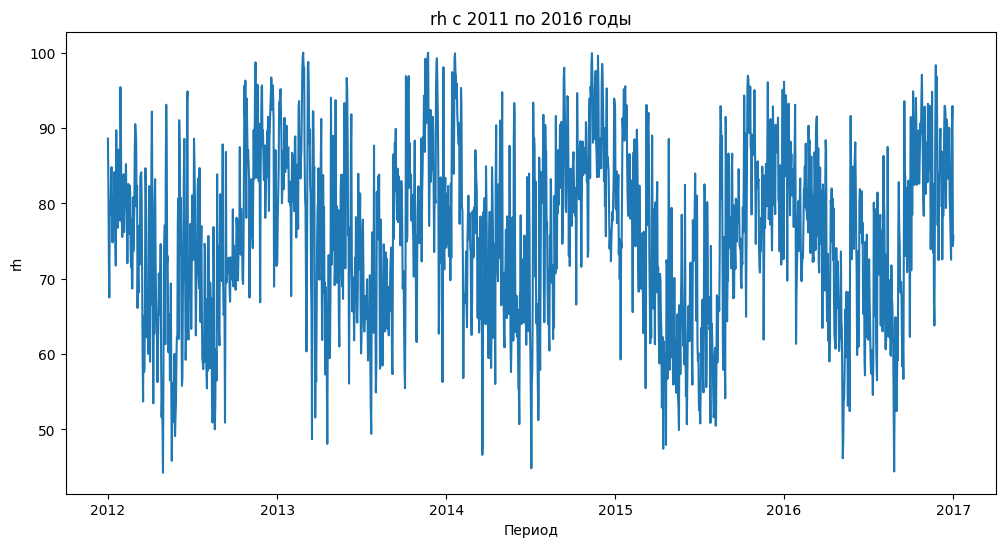

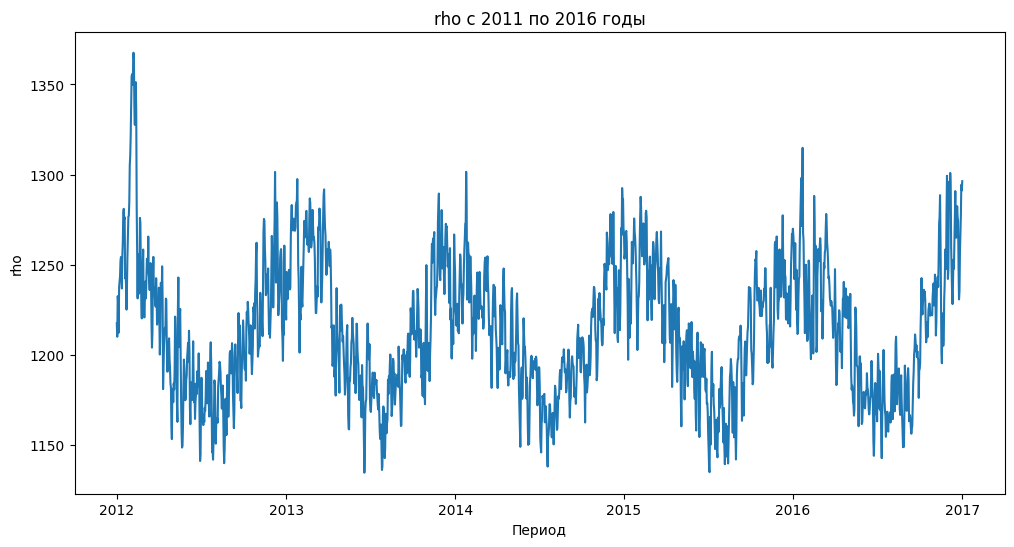

In [20]:
for col in ['rh', 'rho']:
    plot(daily_means[col], col)

In [21]:
fuller(daily_means['rh'])
fuller(daily_means['rho'])

ADF статистика: -4.555734922795384
p-значение: 0.00015573859740747903
Критические значения:
  1%: -3.4339740253219566
  5%: -2.863140805408186
  10%: -2.5676222161097058
ADF статистика: -3.000726806470487
p-значение: 0.03482658142078555
Критические значения:
  1%: -3.4339740253219566
  5%: -2.863140805408186
  10%: -2.5676222161097058


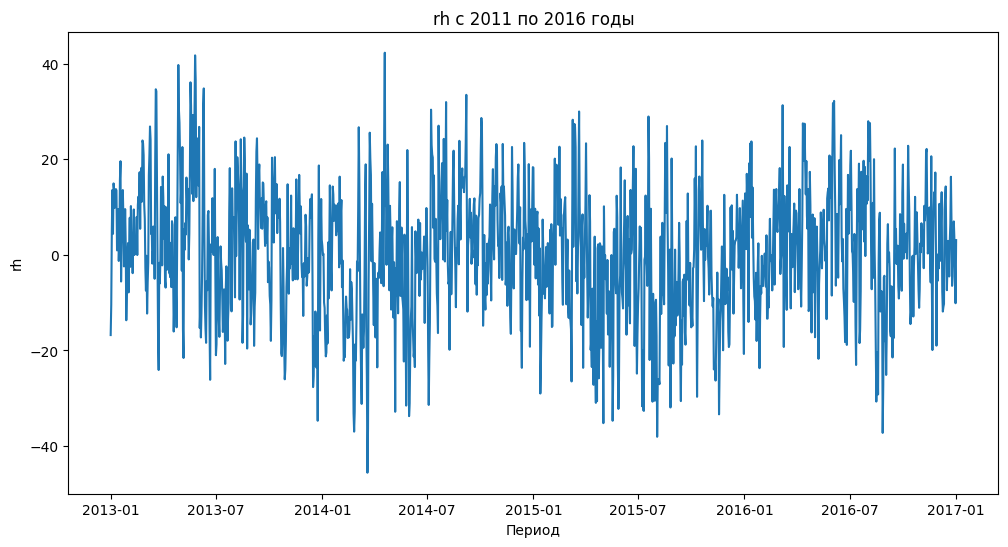

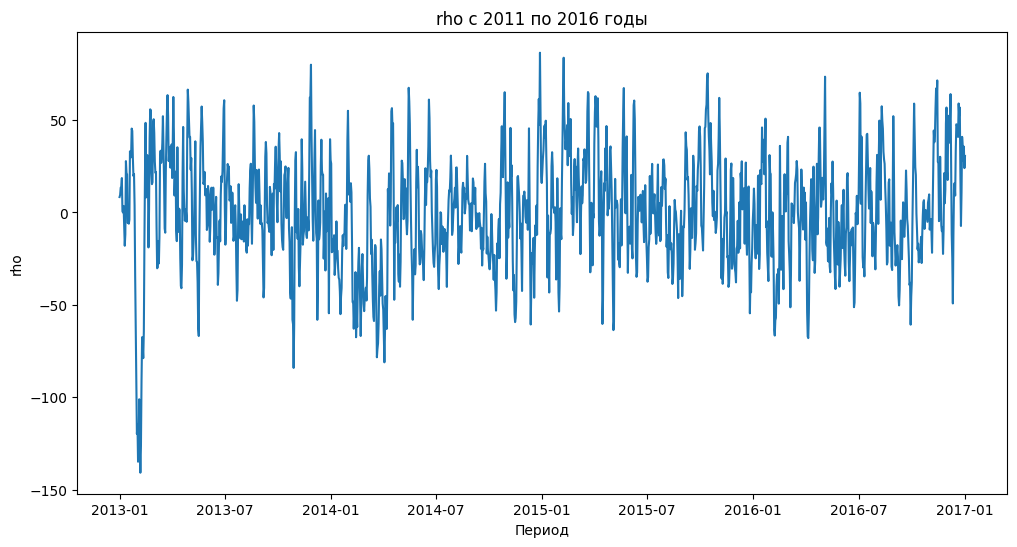

In [22]:
for col in ['rh', 'rho']:
    diff = daily_means[col] - daily_means[col].shift(365)

    diff.dropna(inplace=True)

    daily_means[col+'_diff'] = diff
    
    plot(diff, col)

In [38]:
model = VAR(daily_means[['temp', 'rh', 'rho']])

lag_order = model.select_order(maxlags=10)

print(lag_order.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        13.22       13.23   5.515e+05       13.22
1        9.074       9.110       8724.       9.087
2        8.944       9.007       7660.       8.967
3        8.896      8.987*       7305.      8.930*
4        8.894       9.013       7291.       8.938
5        8.890       9.035       7257.       8.943
6        8.891       9.064       7265.       8.955
7        8.890       9.090       7262.       8.964
8       8.887*       9.115      7240.*       8.971
9        8.891       9.146       7269.       8.985
10       8.890       9.172       7261.       8.994
--------------------------------------------------


c:\Users\Morzhig\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [39]:
model_fit = model.fit(3, ic='hqic')

model_fit.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 15, Dec, 2024
Time:                     19:41:02
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    9.00060
Nobs:                     1823.00    HQIC:                   8.94339
Log likelihood:          -15851.6    FPE:                    7405.29
AIC:                      8.90995    Det(Omega_mle):         7284.75
--------------------------------------------------------------------
Results for equation temp
             coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------
const         -30.659234         7.503239           -4.086           0.000
L1.temp         1.412492         0.058339           24.212           0.000
L1.rh           0.030663         0.007634            4.016           0.000
L1.rho    

In [40]:
model_fit = model.fit(2, ic='hqic')

model_fit.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 15, Dec, 2024
Time:                     19:41:02
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    9.01996
Nobs:                     1824.00    HQIC:                   8.97993
Log likelihood:          -15911.8    FPE:                    7758.44
AIC:                      8.95654    Det(Omega_mle):         7669.79
--------------------------------------------------------------------
Results for equation temp
             coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------
const         -37.236825         7.041766           -5.288           0.000
L1.temp         1.429619         0.056239           25.420           0.000
L1.rh           0.027755         0.007697            3.606           0.000
L1.rho    

In [41]:
from statsmodels.stats.stattools import durbin_watson

dw_stats = durbin_watson(model_fit.resid)

for col, stat in zip(daily_means[['temp', 'rh', 'rho']].columns, dw_stats):
    print(f'{col}: {stat}')

temp: 1.9593403799810793
rh: 2.01195116826059
rho: 1.9469676240289364


c:\Users\Morzhig\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Morzhig\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Morzhig\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


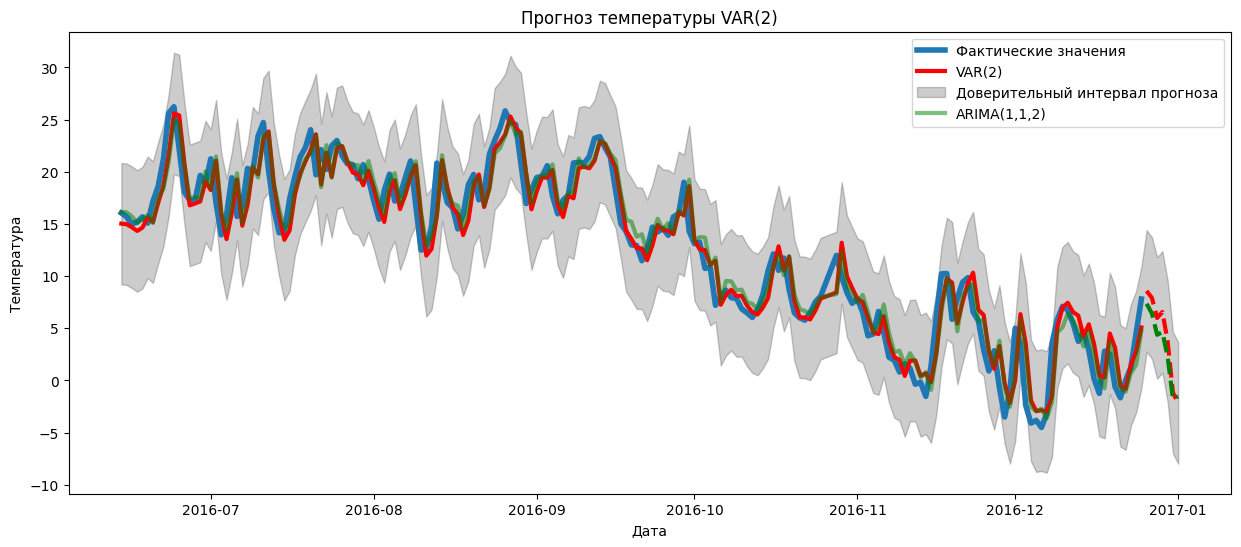

In [48]:
forecast_index = daily_means.index

all_forecasts = []
std_errors = []

for i in range(len(forecast_index)):
    if i >= model_fit.k_ar:
        last_values = daily_means[['temp', 'rh', 'rho']].iloc[i - model_fit.k_ar:i].values
        forecast = model_fit.forecast(last_values, steps=1)
        all_forecasts.append(forecast[0])
        
        cov_matrix = model_fit.sigma_u
        std_error = np.sqrt(np.diag(cov_matrix))
        std_errors.append(std_error[0])  
    else:
        all_forecasts.append([None, None, None])
        std_errors.append(None)

forecast_df = pd.DataFrame(all_forecasts, index=forecast_index, columns=['temp', 'rh', 'rho'])
std_errors = np.array(std_errors, dtype=object)

forecast_df = forecast_df.fillna(forecast_df.mean())

confidence_level = 2.56
lower_bound = forecast_df['temp'].copy()
upper_bound = forecast_df['temp'].copy()

for i in range(len(std_errors)):
    if std_errors[i] is not None:
        lower_bound[i] -= confidence_level * std_errors[i]
        upper_bound[i] += confidence_level * std_errors[i]
    else:
        lower_bound[i] = None
        upper_bound[i] = None

plt.figure(figsize=(15, 6))

plt.plot(daily_means.index[-200:-7], daily_means['temp'][-200:-7], label="Фактические значения", linewidth=4)

plt.plot(forecast_df.index[-200:-7], forecast_df['temp'][-200:-7], color='red', label="VAR(2)", linewidth=3)

plt.fill_between(forecast_df.index[-200:], lower_bound[-200:], upper_bound[-200:], alpha=0.2, color='k', label='Доверительный интервал прогноза')

plt.plot(forecast_df.index[-7:], forecast_df['temp'][-7:], color='red', linestyle='--', linewidth=3)

model_arima = ARIMA(df_temp, order=(1,1,2))
model_arima_fit = model_arima.fit()

forecast_arima = model_arima_fit.get_prediction(start=0, end=len(df_temp)-1)
plt.plot(forecast_arima.predicted_mean[-200:-7], color='g', alpha=0.5, label='ARIMA(1,1,2)', linewidth=3)
plt.plot(forecast_arima.predicted_mean[-7:], color='g', linestyle='dashed', linewidth=3)

plt.title('Прогноз температуры VAR(2)')
plt.xlabel('Дата')
plt.ylabel('Температура')
plt.legend()
plt.show()

In [28]:
print(mean_squared_error(daily_means['temp'], forecast_df['temp']))

5.153051442220696
